# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
import seaborn as sns

import collections

from sklearn.cluster import KMeans

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import classification_report

import xgboost as xgb

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('./Udacity_AZDIAS_052018.csv')
customers = pd.read_csv('./Udacity_CUSTOMERS_052018.csv')
dias_attributes = pd.read_excel('./DIAS Attributes - Values 2017.xlsx')

C:\Users\david\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We get some errors with the data that indicate that two of the columns have mixed data types and thus would need addressing in case it has an affect in our interpritation of the data.

## **azdias dataset**
An exploration of the azdias data, the German population data that can tell us about the general population and we can aim to understand the details that tell us about potetial customer, by comparing the population data to the customer data.

Firstly, what does the population data look like?

In [3]:
azdias.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


We have `367` columns in the population dataset (azdias) with on of the as `Unnamed: 0`, which seem to be a replication of the index.  This can be dropped before we continue with the exploration.

In [4]:
# Drop Unnamed:0 column from the population dataset.
azdias.drop(columns = 'Unnamed: 0', inplace = True)

# To have a good look at the data set the max column view to none.
# This will run true throught this workbook.
pd.set_option('display.max_columns', None)

In [5]:
# Let's get some intel on this data.
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


Wow, thats `267` float64 values, `93` int64 and `6` objects/categorical data.

What does the categorical data look like and in the population data?

In [6]:
# The categorical data of the population.
azdias_objects = azdias.select_dtypes(include='object')
print('Columns count = ', azdias_objects.shape[1])
azdias_objects.head()

Columns count =  6


,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W


There are `6` categorical columns that we should have a little look.
  * **CAMEO_DEU_2105** look like it have categorical code for each person.
  * **CAMEO_DUEG_2015** look like integer values but since it's on this list there must be a mixture of integer and categorical data.  This column will need more review to unify the column.
  * **CAMEO_INTL_2015** again looks like integer values but must also have some categorical data that has it in this group.  This must be the other column with mixed data type that gave us the earlier error.
  * **D19_LETZTER_KAUF_BRANCHE, EINGEFUEGT_AM and OST_WEST_KZ** are categorical columns.
  
Next we should find out if these columns have data that does not belong and thus clean it further.

In [7]:
# just to confirm that the two columns which raised the error
# when the data was loaded.
print(azdias.iloc[:, 18:20].columns)
print(customers.iloc[:, 19:21].columns)

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')
Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


It looks like the suspected columns indeed are the cause of the error when the data was loaded.  We will need to look at these columns to correct this data.  Having a look at the values in these two columns can help find out how to correct this.

In [8]:
azdias['CAMEO_DEUG_2015'].value_counts()

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

In [9]:
azdias['CAMEO_INTL_2015'].value_counts()

51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: CAMEO_INTL_2015, dtype: int64

Look like we have a mixture of int, flaot and string data types in these columns.

In [10]:
def content_fix(df, column):
    '''
    This function corrects the characters used in the CAMEO columns, which raised
    the erros when we load the population and customer datasets.
    '''
    columns = column
    
    # Replace and reformat the columns to float.
    df[columns] = df[columns].replace({'X': np.nan, 
                                       'XX': np.nan, 
                                       ' ': np.nan, 
                                       '': np.nan})
    if (column == 'CAMEO_DEUG_2015') or (column == 'CAMEO_INTL_2015'):
        df[columns] = df[columns].astype('float')
    
    return df

In [11]:
#azdias_pop = feature_correction(azdias, 'CAMEO_DEUG_2015')
#azdias_pop['CAMEO_DEUG_2015'].value_counts()

In [12]:
#azdias_pop = feature_correction(azdias_pop, 'CAMEO_INTL_2015')
#azdias_pop['CAMEO_INTL_2015'].value_counts()

What does the data look like following the changes.

In [13]:
#azdias_pop.info()

Two of the categorical columns have been changed to float data types.

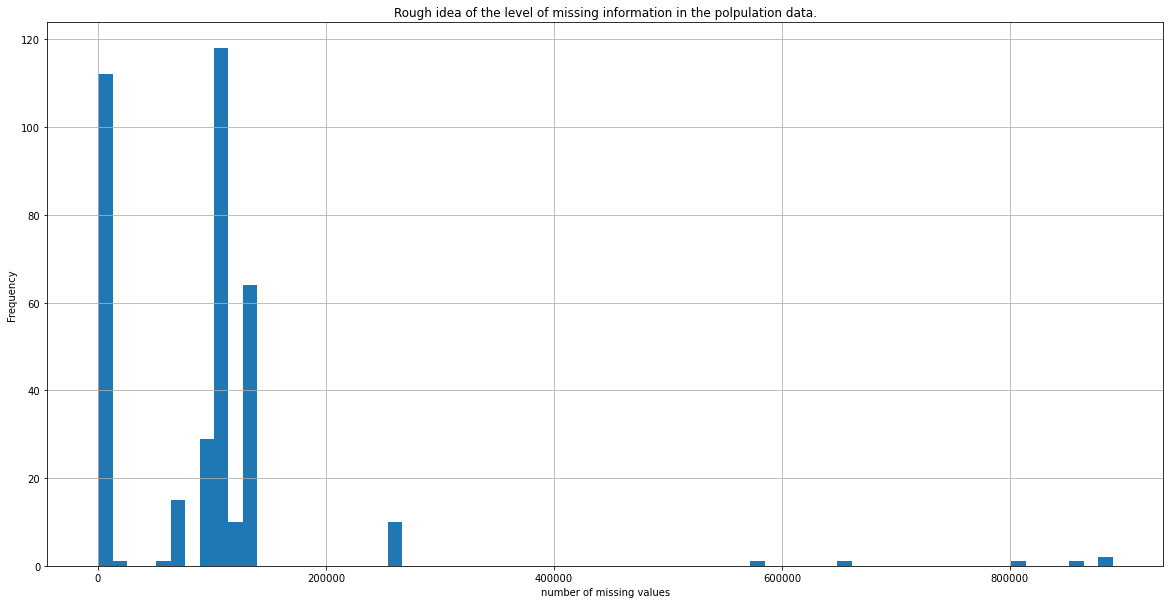

In [14]:
# How mcuh data is missing from the population data.
# how much information is missing for each columns.
pd.set_option('display.max_rows', 100)  # Limits the number of rows shown.

azdias.isnull().sum().plot(kind='hist', bins = 70, figsize = (20,10));
plt.title('Rough idea of the level of missing information in the polpulation data.')
plt.xlabel('number of missing values')
plt.grid()

### Discussion: missing values in population data.
There are some columns that appear to have almost all there values as null values and as such we should look to have a cut of value at which we will drop the data.  Initially I will start by dropping values that have more than `30%` of the data missing.

Before we do that we should look at the datasets that descrinbe the features.  Perhaps, we should see how this will affect our choice for the colimns to keep.

## Dias_attributes:
We will only use this file for a detailed description of the columns we are goin to use because it gives detailed mapping of data values.

In [15]:
dias_attributes.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Attribute,Description,Value,Meaning
1,NaN,AGER_TYP,best-ager typology,-1,unknown
2,NaN,NaN,NaN,0,no classification possible
3,NaN,NaN,NaN,1,passive elderly
4,NaN,NaN,NaN,2,cultural elderly


In [16]:
def dias_attributes_fix(attributes):
    '''
    Function reformats dias_attributes so that if is usable.
    Drops Unnamed: 0 columns, and moves the column names from
    the first row, forward fills the null values and generates
    a cols_to_keep 
    '''
    # Formating dais_attributes dataframe.
    attributes.drop(columns = 'Unnamed: 0', inplace = True)
    attributes.drop(index = 0, axis = 0, inplace = True)
    attributes.columns = ['Attribute',	'Description', 'Value', 'Meaning']
    attributes.reset_index(drop = True, inplace = True)
    
    # Lets fill the nan values with the previous values.
    attributes.fillna(method = 'ffill', inplace = True)

    cols_to_keep = attributes['Attribute'].unique().tolist()
    
    print('Dias_attributes has been transformed.')
    
    return attributes, cols_to_keep

In [17]:
attributes_df, cols_to_keep = dias_attributes_fix(dias_attributes)

Dias_attributes has been transformed.


In [18]:
attributes_df.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


Now we take this reformated attributes data and create a dataframe that hold only the missing values holders in the attributes that have been used to indicate that the data was not give or is missing.

In [19]:
def unknowns_values(attributes):
    '''
    This function formats the dais_attributes data and gives the unknown values
    in the data have been assigned.
    '''
    # drop the numerical values columns from attributes we wnat to keep them.
    #attributes = attributes.set_index('Attribute')
    #attributes = attributes.drop(['ANZ_HAUSHALTE_AKTIV',
    #                            'ANZ_HH_TITEL', 
    #                            'ANZ_PERSONEN', 
    #                            'ANZ_TITEL',
    #                            'GEBURTSJAHR',
    #                            'KBA13_ANZAHL_PKW',
    #                            'MIN_GEBAEUDEJAHR'], 
    #                          axis=0)
    
    #uk_attributes = attributes.reset_index()
    # which meaning might indicate unknowns.
    unknown = attributes[attributes['Meaning'].str.contains('unknown')]
    
    # Fix the cells with two values.
    unknown['Value'] = unknown['Value'].astype(str)
    unknown_2 = unknown['Value'].str.split(',').apply(pd.Series)
    unknown_2.index = unknown.set_index(['Attribute', 'Description', 'Meaning']).index
    unknown_2 = unknown_2.stack().reset_index(['Attribute', 'Description', 'Meaning'])
    unknown_2 = unknown_2.reset_index()
    unknown_2.drop(columns = 'index', inplace = True)
    unknown_2.rename(columns = {0: 'Value'}, inplace = True)
    
    # Convert the values into interger values.
    unknown_2['Value'] = unknown_2['Value'].astype('int64')
    
    return unknown_2

In [20]:
unknown_values_df = unknowns_values(attributes_df)
unknown_values_df.head()

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Attribute,Description,Meaning,Value
0,AGER_TYP,best-ager typology,unknown,-1
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,unknown,-1
2,ALTERSKATEGORIE_GROB,age classification through prename analysis,unknown,0
3,ALTER_HH,main age within the household,unknown / no main age detectable,0
4,ANREDE_KZ,gender,unknown,-1


In [21]:
unknown_values_df['Value'].value_counts()

-1    230
 9     75
 0     19
Name: Value, dtype: int64

We can now look to update the columns in the population dataset with nan values where there unknowns were.

In [22]:
def cleaning(df, unknown_values_df, cols_to_keep, train = 'train'):
    '''
    This function converts the unknown values in the dataframe to null values,
    drops rows that have more than 50% missing data and drop columns we have no
    definitions for in attributes.
    '''
    # Drop the Unnamed:0 column in the data
    if 'Unnamed: 0' in df.columns:
        df.drop(columns = 'Unnamed: 0', inplace = True)
    
    iden = df.pop('LNR')
    # Fix the CAMEO_DEU_2015 missing values recorded as 'X' or 'XX'.
    df = content_fix(df, column = 'CAMEO_DEUG_2015')
    df = content_fix(df, column = 'CAMEO_DEU_2015')

    # Takes the unknown values recorded in Meaning and change them in df for null.
    print('-------------------------------------------------------------')
    print('----- Converting unknown values to null in training df. -----')
    print('-------------------------------------------------------------')
    #---------------------------------------------------------------------------------------
    for row in unknown_values_df.iterrows():
        missing_values = int(row[1]['Value'])
        attrib = row[1]['Attribute']
        
        if attrib not in df.columns:
            continue
        
        if isinstance(missing_values, int):
            df[attrib].replace(missing_values, np.nan, inplace=True)
        elif isinstance(missing_values, str):
            eval("df[dias_attributes].replace(["+missing_values+"], np.nan, inplace=True)")
    
    print('-------------------------------------------------------------')
    print('-------------- Conversion of data complete. -----------------')
    print('-------------------------------------------------------------')
    
    if train == 'train':
        # Assess how many missing values per row then remove those over 50%.
        row_nulls = df.isnull().sum(axis = 1)
        cols_len = df.shape[1]
        df = df.loc[row_nulls[row_nulls <= 0.5 * cols_len].index]
        df.reset_index(drop = True, inplace = True)
        
        
        # Split the features and lebels
        train_response = df['RESPONSE']
        features = df.drop('RESPONSE', axis = 1)
        
        features = features.filter(cols_to_keep)
        
        print('-------------------------------------------------------------')
        print('----------  features and train_response ready. --------------')
        print('-------------------------------------------------------------')
        
        return features, train_response, iden
    elif train == 'customers':
        # For the customer data take the customer specific columns.
        cust_response = df[['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']]
        features = df.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], 
                           axis = 1)
        features = features.filter(cols_to_keep)
        
        print('-------------------------------------------------------------')
        print('-------------  customer features and type ready -------------')
        print('-------------------------------------------------------------')
        
        return features, cust_response, iden
        
    else:
        # Drop columns not in attributes.
        features = df.filter(cols_to_keep)
        
        print('-------------------------------------------------------------')
        print('-------------------  features ready -------------------------')
        print('-------------------------------------------------------------')
        
        return features, iden

In [24]:
# Clean the population data.
pop_features, pop_lrn  = cleaning(azdias, 
                             unknown_values_df, 
                             cols_to_keep, 
                             train = 'pop')

-------------------------------------------------------------
----- Converting unknown values to null in training df. -----
-------------------------------------------------------------
-------------------------------------------------------------
-------------- Conversion of data complete. -----------------
-------------------------------------------------------------
-------------------------------------------------------------
-------------------  features ready -------------------------
-------------------------------------------------------------


In [25]:
pop_features.shape

(891221, 272)

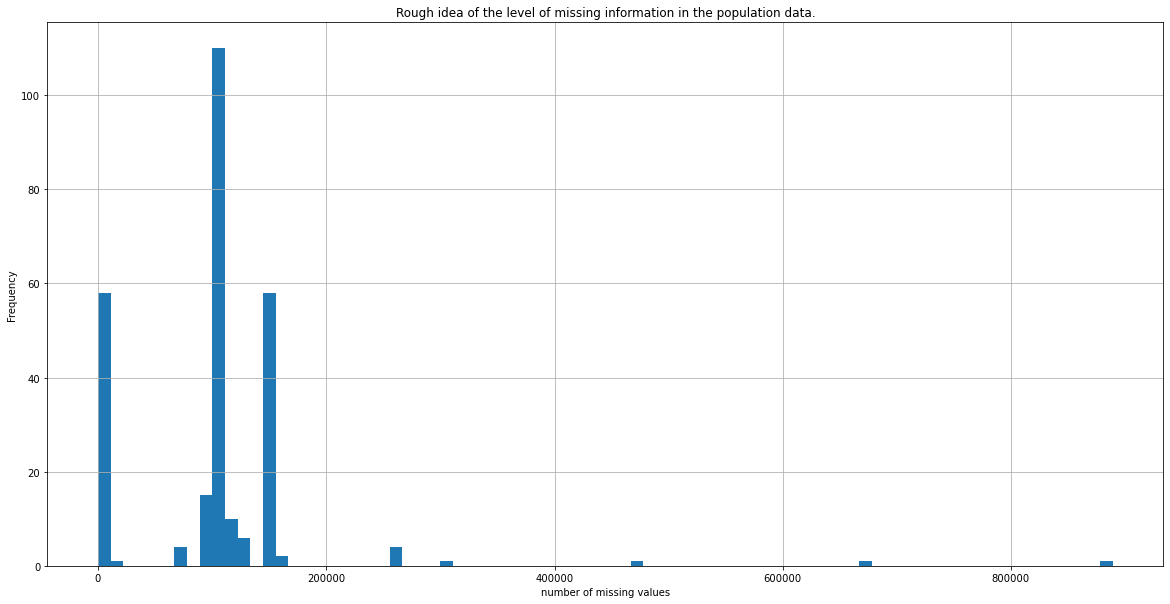

In [26]:
# Missining values in pop_features.
pop_features.isnull().sum().plot(kind='hist', bins = 80, figsize = (20,10));
plt.title('Rough idea of the level of missing information in the population data.')
plt.xlabel('number of missing values')
plt.grid()

In [27]:
pop_over30pc = pop_features.isnull().mean()[pop_features.isnull().mean() > 0.3] * 100
pop_over30pc.reset_index().rename({'index': 'Attribute', 0: '% missing'}, axis = 1)

,Attribute,% missing
0,AGER_TYP,76.019640
1,ALTER_HH,34.813699
2,KBA05_BAUMAX,53.468668
3,TITEL_KZ,99.757636


In [28]:
# Finding out what data is held in these columns, use this.
pop_30_cols = attributes_df[attributes_df['Attribute'] == 'REGIOTYP']
pop_30_cols

,Attribute,Description,Value,Meaning
2070,REGIOTYP,neighbourhood,"-1, 0",unknown
2071,REGIOTYP,neighbourhood,1,upper class
2072,REGIOTYP,neighbourhood,2,conservatives
2073,REGIOTYP,neighbourhood,3,upper middle class
2074,REGIOTYP,neighbourhood,4,middle class
2075,REGIOTYP,neighbourhood,5,lower middle class
2076,REGIOTYP,neighbourhood,6,traditional workers
2077,REGIOTYP,neighbourhood,7,marginal groups


### Missing values: Columns with over 30%
A look at the columns with over 30% of there data missing resulted wit 4 columns:
  * **AGER_TYP** which is the age bracket of the individual (passive elderly, cultural elderly, experience-driven elderly, no classification possible) - 76% missing.
  * **ALTER_HH** this is the main age within the household and is a range between dates e.g value of 1 means 01.01.1895 to 31.12.1899.  - 35% missing.
  * **KBA05_BAUMAX** describes the number of families within a microcell.  This refers really to the building type the person lives.  - 53% missing.
  * **TITEL_KZ** details whether a person holds an academic title.  - 99.7% missing.
  
These columns are up for consideration to drop.  Two of these tell us about the age of the person and KBA05_MAXAH column (which has 16% missing data) tells us the age bracket someone is still in the data set.  This only has 16% missing data and that covers what these two columns do.  Given this I will drop the AGER_TYP and ALTER_HH.  The other 2 will also be drop as thy have too large a number of missing values to work with.

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [29]:
# Clean the customer data.
cust_features, cust_labels, cust_lrn = cleaning(customers, 
                                                    unknown_values_df, 
                                                    cols_to_keep, 
                                                    train='customers')

-------------------------------------------------------------
----- Converting unknown values to null in training df. -----
-------------------------------------------------------------
-------------------------------------------------------------
-------------- Conversion of data complete. -----------------
-------------------------------------------------------------
-------------------------------------------------------------
-------------  customer features and type ready -------------
-------------------------------------------------------------


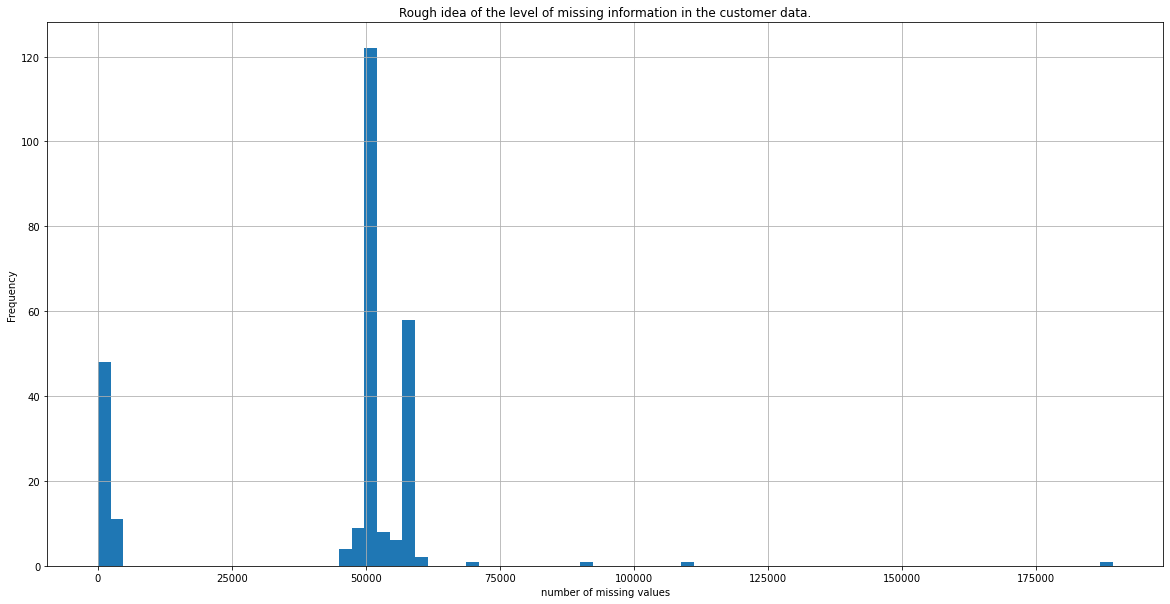

In [30]:
# Missining values in cust_features.
cust_features.isnull().sum().plot(kind='hist', bins = 80, figsize = (20,10));
plt.title('Rough idea of the level of missing information in the customer data.')
plt.xlabel('number of missing values')
plt.grid()

In [31]:
cust_over30pc = cust_features.isnull().mean()[cust_features.isnull().mean() > 0.3] * 100
cust_over30pc.reset_index().rename({'index': 'Attribute', 0: '% missing'}, axis = 1)

,Attribute,% missing
0,AGER_TYP,48.059504
1,ALTER_HH,35.870745
2,KBA05_BAUMAX,57.153069
3,KKK,31.340137
4,REGIOTYP,31.340137
5,TITEL_KZ,98.793647


### Missing values: columns with more than 30% null.
As in the population data we have the similar features with more than 30% missing data, these are:
  * **AGER_TYP**
  * **ALTER_HH**
  * **KBA05_BAUMAX**
  * **TITEL_KZ**

The customer data also has:
  * **KKK** This is the purchasing power that a person has ranked from very high to low.
  * **REGIOTYP** is the neighborhood class from upper class to merginal group.

In [32]:
cust_features.shape

(191652, 272)

In [33]:
pop_features.shape

(891221, 272)

Looking at the shape of the customer and population features we see that the have the same shape but different number of entries as would be expected.

## Feature Selection.

In [34]:
#cust_labels

In [35]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import Normalizer

In [36]:
cust_features.drop(['AGER_TYP', 'ALTER_HH', 'KBA05_BAUMAX', 'TITEL_KZ'], axis = 1, inplace=True)
pop_features.drop(['AGER_TYP', 'ALTER_HH', 'KBA05_BAUMAX', 'TITEL_KZ'], axis = 1, inplace=True)

In [ ]:
#cust_features.to_csv('customer_features.csv')

In [ ]:
#cust_labels.to_csv('customer_labels.csv')

In [ ]:
#cust_lrn.to_csv('customer_id.csv')

In [ ]:
#pop_features.to_csv('population_features.csv')

In [ ]:
#pop_lrn.to_csv('population_lrn.csv')

In [37]:
def dummy_variables(df, cat_cols, dummy_na=False):
    '''
    Function finds all categorical columns, creats dummy variables and deletes the original.
    
    Inputs:
        df - dataframe to use.
        cat_cols - a list of the categorical column in the dataframe.
        dummy_na - Set to false.
        
    Output:
       df - dataframe with the categorical columns replaced with their dummy variables.
    '''
    for col in cat_cols:
        try:
            # for eact category add a dummy variable and drop the original colunn.
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
            
        except:
            continue
    return df

In [38]:
cat_df = cust_features.select_dtypes(include='object')
cat_cols = cat_df.columns

# Create the dummy variables from the categorical columns in df.
cust_features_dum = dummy_variables(cust_features, cat_cols, dummy_na=False)

In [39]:
imputer = SimpleImputer(strategy='most_frequent')
cust_features_im = imputer.fit_transform(cust_features_dum)

# dimentionality reduction
scaler = Normalizer()
scaler.fit(cust_features_im)
StandardScaler(copy=True, with_mean=True, with_std=True)

cust_features_scaled = scaler.transform(cust_features_im)

In [40]:
cust_features_scaled.shape

(191652, 310)

In [41]:
#Lets get the columns back onto the data.
cust_features_scaled = pd.DataFrame(cust_features_scaled)
cust_features_scaled.columns = cust_features_dum.columns
cust_features_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,EWDICHTE,FINANZTYP,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_0_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_180,KBA13_KMH_0_140,KBA13_KMH_140_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_0_60,KBA13_KW_70,KBA13_KW_61_120,KBA13_KW_80,KBA13_KW_90,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU

In [42]:
# Lets get only the data for the customer group.
# This was we can be more targeted customer who will return more than once.
cust_label = pd.DataFrame(cust_labels['CUSTOMER_GROUP'])

cust_label_dum = pd.get_dummies(cust_label['CUSTOMER_GROUP'], prefix='CUSTOMER_GROUP', prefix_sep='_', drop_first=False, dummy_na=False)
cust_label_dum.drop(columns = 'CUSTOMER_GROUP_SINGLE_BUYER', inplace=True)

In [43]:
cust_label_dum.head()

,CUSTOMER_GROUP_MULTI_BUYER
0,1
1,0
2,1
3,1
4,1


In [44]:
# Finding out which features we should use.
model_features = SelectKBest(score_func=chi2, k=30)
fit = model_features.fit(cust_features_scaled, cust_label_dum)

In [45]:
result_features = pd.DataFrame(fit.scores_)
result = result_features.transpose()
result.columns = cust_features_dum.columns
result

,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,EWDICHTE,FINANZTYP,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_0_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_180,KBA13_KMH_0_140,KBA13_KMH_140_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_0_60,KBA13_KW_70,KBA13_KW_61_120,KBA13_KW_80,KBA13_KW_90,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU

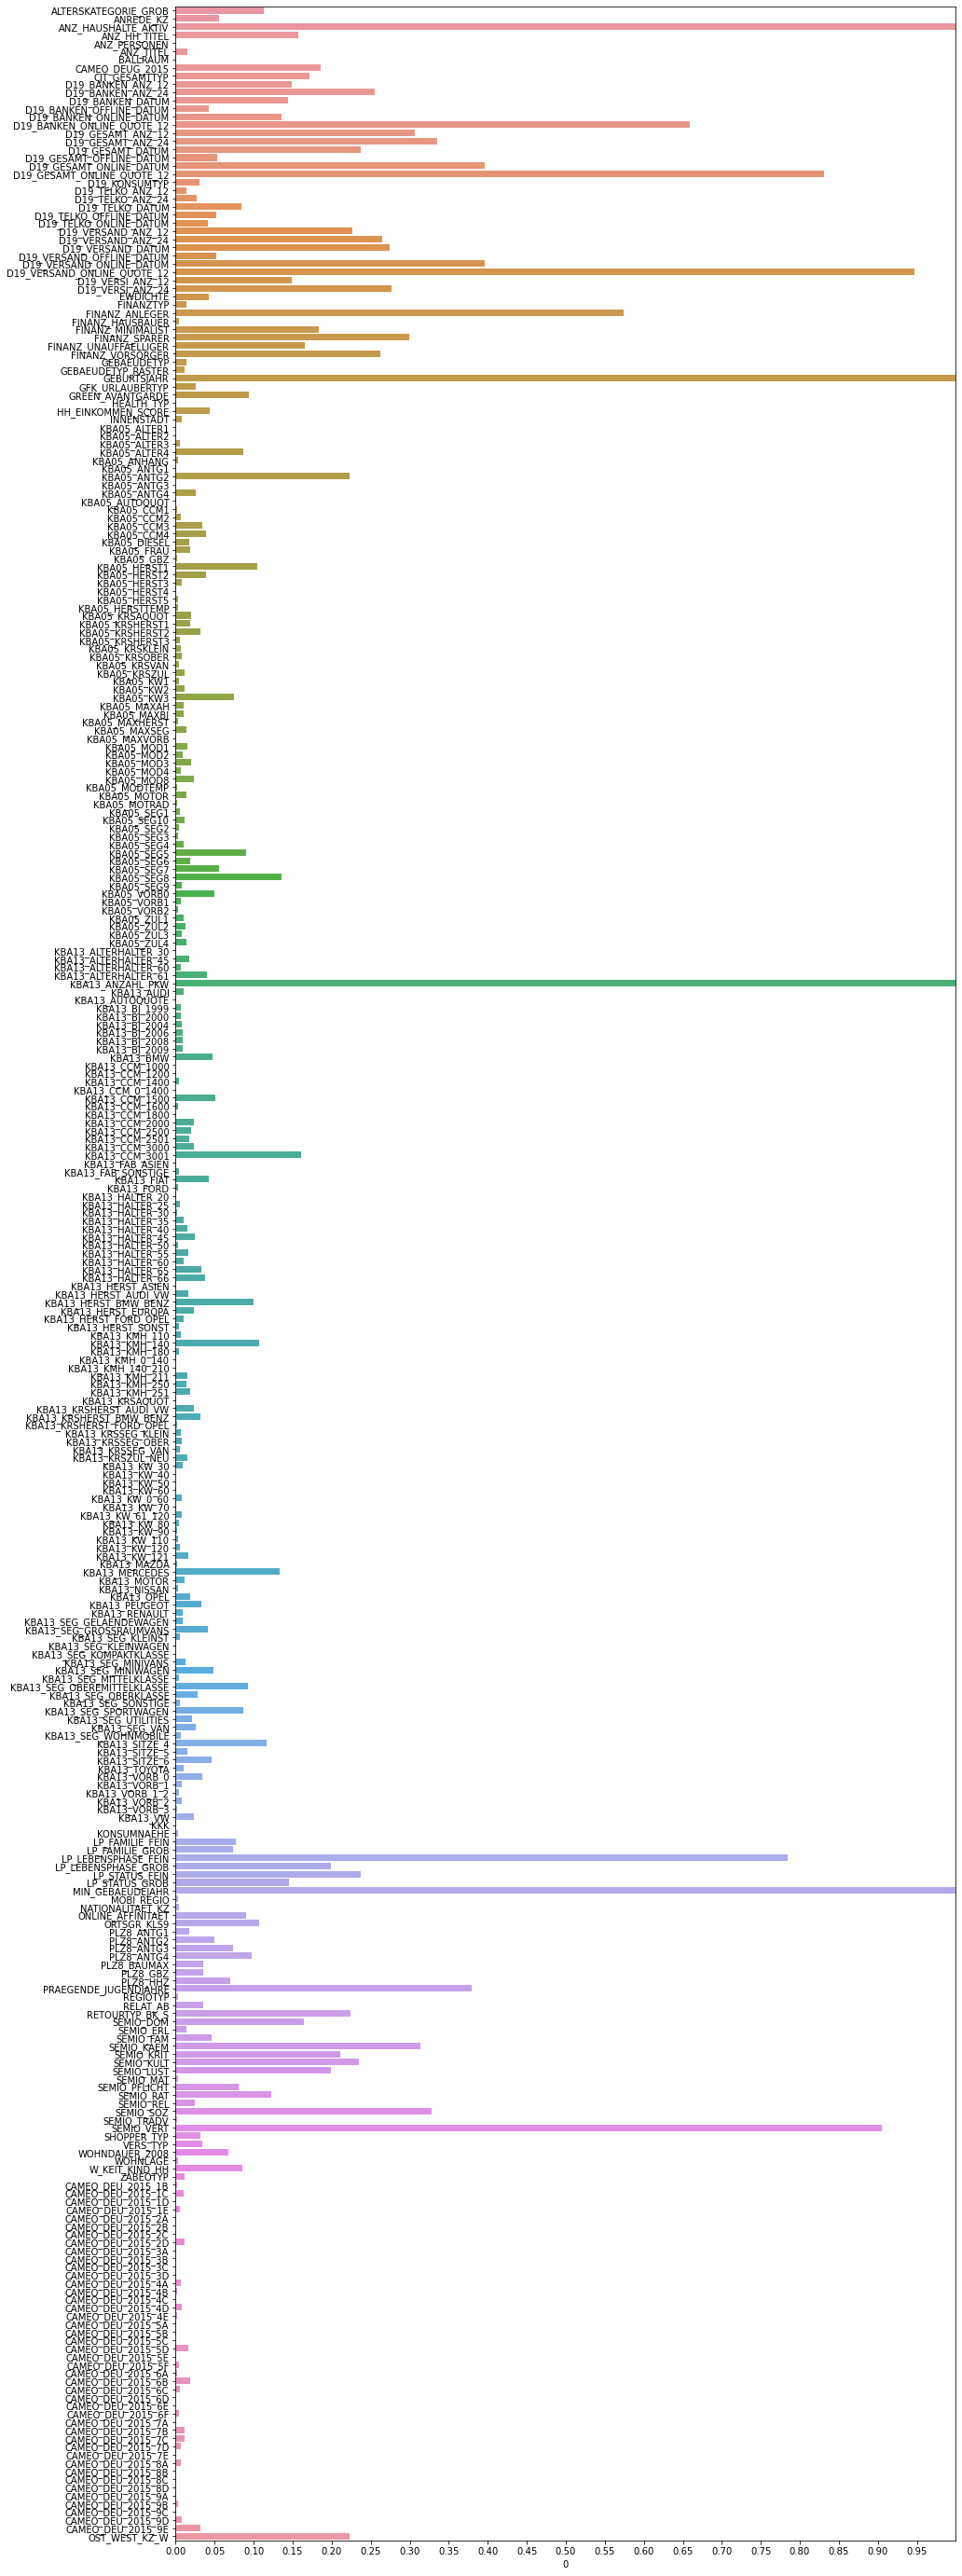

In [47]:
# plot the score to find a good selection of columns to reduce the size for computation and model improvement.
plt.figure(figsize=(15, 50))
sns.barplot(result.iloc[0],result.columns)
plt.xlim(0,1)
plt.xticks(np.arange(0,1,0.05));

In [49]:
# Good columns for return customer is:
best_cols = []
worst_cols = []

for i in result.columns:
    # We want all the columns with a score greter than 0.1.
    if result[i].iloc[0] > 0.01:
        best_cols.append(i)
    else:
        worst_cols.append(i)

In [50]:
best_cols

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_TITEL',
 'CAMEO_DEUG_2015',
 'CJT_GESAMTTYP',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_DATUM',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'EWDICHTE',
 'FINANZTYP',
 'FINANZ_ANLEGER',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_VORSORGER',
 'GEBAEUDETYP',
 'GEBAEUDETYP_RASTER',
 'GEBURTSJAHR',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE

In [51]:
len(worst_cols)

143

In [52]:
len(best_cols)

167

### Discussion:
The features column can now be reduce to 53 columns which will make the modelling less cumputaionally intensive and may improve the performace of the model.  That is 257 columns dropped whith a score less than 0.1 from the SelectKBest and chi2.

In [53]:
new_cust_features = cust_features_scaled.drop(columns=worst_cols, axis=1)
new_cust_features.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_TITEL,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,EWDICHTE,FINANZTYP,FINANZ_ANLEGER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HH_EINKOMMEN_SCORE,KBA05_ALTER4,KBA05_ANTG2,KBA05_ANTG4,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_HERST1,KBA05_HERST2,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSZUL,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MOD1,KBA05_MOD3,KBA05_MOD8,KBA05_MOTOR,KBA05_SEG10,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_VORB0,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL4,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_BMW,KBA13_CCM_1500,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FIAT,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_55,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_KMH_140,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSZUL_NEU,KBA13_KW_121,KBA13_MERCEDES,KBA13_MOTOR,KBA13_OPEL,KBA13_PEUGEOT,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_VORB_0,KBA13_VW,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,ONLINE_AFFINITAET,ORTSGR_KLS9,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,RELAT_AB,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,WOHNDAUER_2008,W_KEIT_KIND_HH,ZABEOTYP,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_9E,OST_WEST_KZ_W
0,0.001719,0.000430,0.000430,0.0,0.0,0.000430,0.002149,0.000000,0.000000,0.004298,0.004298,0.004298,0.0,0.000000,0.000000,0.003868,0.003868,0.004298,0.000000,0.001289,0.0,0.000000,0.004298,0.004298,0.004298,0.000000,0.000000,0.003868,0.003868,0.004298,0.000000,0.0,0.0,0.000860,0.000860,0.000430,0.002149,0.000430,0.000860,0.002149,0.000430,0.001719,0.000000,0.001719,0.00043,0.000430,0.001719,0.000860,0.0,0.001289,0.000430,0.000430,0.001719,0.001719,0.001289,0.001719,0.001719,0.001289,0.000860,0.001289,0.001289,0.002149,0.000860,0.001289,0.000860,0.001289,0.000860,0.001719,0.000860,0.001289,0.001289,0.00043,0.000000,0.000430,0.001719,0.001289,0.001719,0.001289,0.000860,0.001289,0.516138,0.001719,0.002149,0.001719,0.001719,0.001719,0.000000,0.001289,0.001289,0.001289,0.001289,0.000860,0.002149,0.001719,0.001289,0.001719,0.001719,0.000860,0.001289,0.001719,0.001289,0.001289,0.000430,0.001719,0.001289,0.001289,0.001289,0.001289,0.001719,0.001289,0.000860,0.002149,0.001289,0.000430,0.001719,0.001289,0.001719,0.001719,0.001719,0.001289,0.000430,0.002149,0.001719,0.001719,0.000860,0.000860,0.008595,0.002149,0.004298,0.002149,0.856076,0.001289,0.000860,0.001289,0.001289,0.000430,0.000000,0.000430,0.002149,0.002149,0.001719,0.000430,0.002149,0.000430,0.001289,0.002149,0.000430,0.001289,0.001719,0.003008,0.000860,0.000430,0.000860,0.002579,0.002579,0.001289,0.000430,0.003868,0.002579,0.001289,0.0,0.00000,0.0,0.000000,0.0,0

In [54]:
new_cust_features.shape

(191652, 167)

### Discusion:
I am happy with the 53 columns I am happy to proceed with the 53 columns that remain if I encounter some misgiving in the data I will return to this point to reduce the number even further.

In [55]:
## Using PCA for features engineering
pca = PCA(n_components=30)

In [56]:
pca.fit(cust_features_scaled)

PCA(n_components=30)

In [57]:
all_features = range(pca.n_components_)

(0.0, 0.0002)

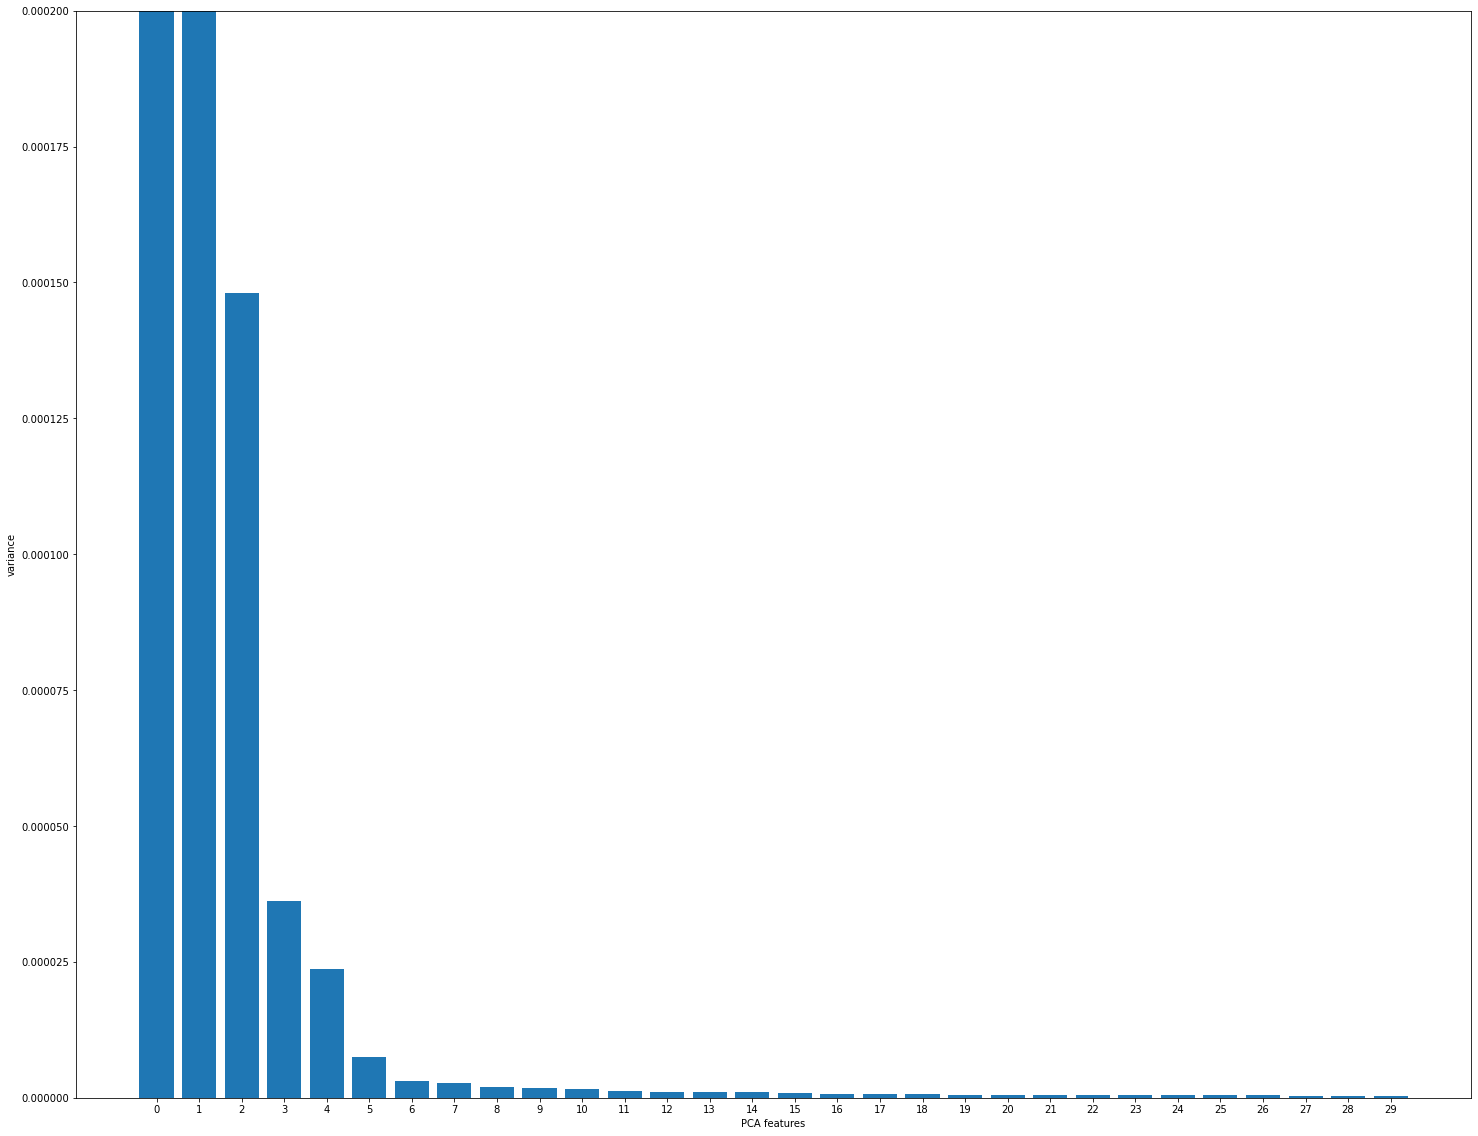

In [58]:
plt.figure(figsize=(25, 20))
plt.bar(all_features, pca.explained_variance_)
plt.xticks(all_features)
plt.ylabel('variance')
plt.xlabel('PCA features')
plt.ylim(np.arange(0,0.0003,0.0002))

In [59]:
pca_features = pca.transform(cust_features_scaled)

In [60]:
pca_features.shape

(191652, 30)